In [ ]:
!pip install requests

### Library

In [ ]:
import pandas as pd
import numpy as np
import urllib.request
import requests
import cv2
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
import joblib

###Load Dataset

In [ ]:
#Load Dataset
git_url = '/content/dataset.csv'
ds = pd.read_csv(git_url, delimiter=',')
ds.head()

,product_id,gender_product,temperature,usage,productDisplayName,city,link
0,16193,Men,Cold,Casual,Puma Men Knitted Vest Green Sweater,Sulawesi Selatan,http://assets.myntassets.com/v1/images/style/p...
1,20228,Women,Cold,Casual,Wrangler Women Cable Red Sweater,Sulawesi Selatan,http://assets.myntassets.com/v1/images/style/p...
2,59620,Women,Hot,Ethnic,FNF Green & Black Wedding Collection Sari,Sulawesi Selatan,http://assets.myntassets.com/v1/images/style/p...
3,12282,Men,Cold,Formal,Genesis Men Green & Purple Striped Shirt,Sulawesi Selatan,http://assets.myntassets.com/v1/images/style/p...
4,53051,Women,Cold,Ethnic,FNF Maroon Printed Sari,Sulawesi Selatan,http://assets.myntassets.com/v1/images/style/p...


### API OpenWeatherMap



In [ ]:
base_url = "http://api.openweathermap.org/data/2.5/weather?"
API_KEY = '5b48d68ce066834a01e3b108a9e5891a'
city = input("Masukkan Nama Provinsi : ")

url = base_url + "appid=" + API_KEY + "&q=" + city
response=requests.get(url).json()

def kelvin_to_celcius(kelvin):
  celcius = kelvin - 273.15
  return celcius

temp_kelvin=response['main']['temp']
temp_celcius=kelvin_to_celcius(temp_kelvin)
feels_like_kelvin = response['main']['feels_like']
feels_like_celcius = kelvin_to_celcius(feels_like_kelvin)

print(f"Temperature in {city}: {temp_celcius:.2f}°C")
print(f"Temperature in {city} feels like: {feels_like_celcius:.2f}°C")

Masukkan Nama Provinsi : Jawa Barat
Temperature in Jawa Barat: 21.19°C
Temperature in Jawa Barat feels like: 21.77°C



### Konversi Suhu

In [ ]:
def convert_temperature(temperature):
    if temperature < 20:
        temperature = "Cold"
    elif temperature >=20 and temperature <30:
        temperature = "Normal"
    elif temperature >=30:
        temperature = "Hot"

    return temperature

temperature = convert_temperature(temp_celcius)
print(f"Musim untuk suhu {temp_celcius:.1f}°C termasuk kategori : {temperature}")


Musim untuk suhu 21.2°C termasuk kategori : Normal


### Model Cosine Similarity

Inputan = Men, Women, Boys

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


gender_product : Men


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


Rekomendasi outfit Men di provinsi Jawa Barat:
       product_id gender_product temperature   usage  \
4545        32768            Men      Normal  Casual   
5251        11346            Men      Normal  Casual   
10761       44579            Men      Normal  Casual   
11699        4401            Men      Normal  Casual   
13657       37808            Men      Normal  Formal   

                                      productDisplayName        city  \
4545                      Music Men Printed Grey T-shirt  Jawa Barat   
5251                          Lee Men Blue Zed Fit Jeans  Jawa Barat   
10761                            Lee Men Blue Pent Jeans  Jawa Barat   
11699  Jimi Hendrix Men's Guitar Signature Black T-shirt  Jawa Barat   
13657               John Players Men Satin Striped Shirt  Jawa Barat   

                                                    link  
4545   http://assets.myntassets.com/v1/images/style/p...  
5251   http://assets.myntassets.com/v1/images/style/p...  
10761 

[4401, 32768, 11346, 44579, 37808]

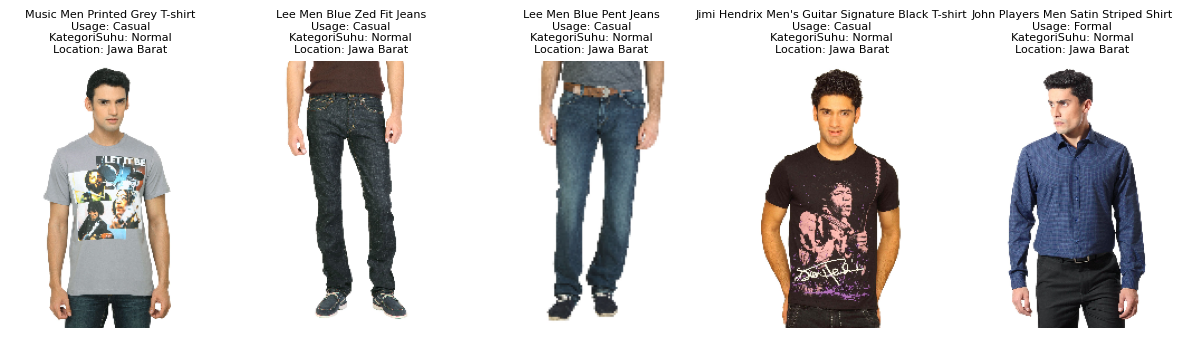

In [ ]:
features = ds[['gender_product','temperature','city']]
targets = ds['product_id']

onehot_encoder = OneHotEncoder(sparse=False)
features_onehot = onehot_encoder.fit_transform(features)


def recommend_outfits(gender_product, temperature,city):

    query_vector = onehot_encoder.transform(np.array([gender_product,temperature,city]).reshape(1, -1))

    similarities = cosine_similarity(query_vector, features_onehot)

    top_n = 5
    sorted_indices = similarities.argsort()[0][-top_n:]

    recommended_outfits = targets.iloc[sorted_indices].tolist()

    print(f"Rekomendasi outfit {gender_product} di provinsi {city}:")

    filtered_df = ds[ds['product_id'].isin(recommended_outfits)].head(top_n)
    print(filtered_df)
    plt.figure(figsize=(15, 10))
    for idx, row in filtered_df.iterrows():
            req = urllib.request.urlopen(row['link'])
            image_array = np.asarray(bytearray(req.read()), dtype=np.uint8)
            image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
            resized_image = cv2.resize(image, (0, 0), fx=0.1, fy=0.1)

            ax = plt.subplot(1, top_n, list(filtered_df.index).index(idx) + 1)
            plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            ax.set_title(f"{row['productDisplayName']}\nUsage: {row['usage']}\nKategoriSuhu: {row['temperature']}\nLocation: {row['city']}", fontsize=8)

    true_relevant_product_ids = ds['product_id'].tolist()

    predicted_relevant_product_ids = recommended_outfits

    #Precision
    precision = len(set(true_relevant_product_ids) & set(predicted_relevant_product_ids)) / len(predicted_relevant_product_ids)

    #Recall
    recall = len(set(true_relevant_product_ids) & set(predicted_relevant_product_ids)) / len(true_relevant_product_ids)

    #MRR
    mrr = 0
    for i, product_id in enumerate(predicted_relevant_product_ids):
        if product_id in true_relevant_product_ids:
            mrr += 1 / (i + 1)

    mrr /= len(predicted_relevant_product_ids)

    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"MRR: {mrr:.3f}")

    return recommended_outfits


x=input("gender_product : ")

recommend_outfits(x,temperature,city)


Parameter yang dimasukkan

1.   Gender Product
2.   Suhu
3.   home_location

- API Open Weather Map Untuk Mendeteksi Suhu
- fungsi konversi suhu masuk ke dalam kategori apa?




### Save Model to Joblib File

In [ ]:
# Save
joblib.dump(onehot_encoder, 'onehot_encoder.pkl')

print("Model and data saved successfully.")

Model and data saved successfully.
